In [1]:
import dimod
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import dwave.samplers
from dwave.system import DWaveSampler
from sklearn.preprocessing import normalize
import seaborn as sns
import json 
from pathlib import Path
import timeit


In [2]:
def set_qubo_weights(Q: np.ndarray, alpha) -> np.ndarray:
    Q_copy = Q.copy()
    matrix_pVj = np.diag(np.diag(Q_copy))
    np.fill_diagonal(Q_copy, 0)
    Q_w = (1-alpha) * Q_copy + (alpha)*matrix_pVj
    Q_w = normalize(Q_w,axis=1, norm='l1')
    return Q_w

def upper_tri_qubo(Q):
    Q_copy = Q.copy()
    diagonal = np.diag(np.diag(Q_copy))
    np.fill_diagonal(Q_copy, 0)
    upper_tri = 2* np.triu(Q_copy)
    q_matrix = diagonal + upper_tri
    return q_matrix

def remove_features(m: np.ndarray, index_to_column_mapping: list[str], remove_indx):
    m_filtered = np.delete(m,remove_indx,0)
    m_filtered = np.delete(m_filtered,remove_indx,1)
    filtered_index_to_column_mapping = np.delete(index_to_column_mapping,remove_indx)
    
    return m_filtered, filtered_index_to_column_mapping

In [3]:
def get_feature_indx(feature_name: str, feature_names: np.array):
    return feature_names.tolist().index(feature_name)

In [4]:
sns.set_theme()
sns.set(font_scale=1.5)
#plt.figure(figsize=(10, 5), dpi=200)
plt.rcParams["figure.figsize"] = (20,10)

def plot_enumerate(results, save_dir, param, title=None):
    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]
    
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    plt.savefig(f'{save_dir}/alpha_{param}_enumerate.png')
    plt.close()


def plot_energies(results,save_dir, param, title=None):
    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]

    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df['indx_round'] = df.index
    df = df.round(4)
    df.index = df['indx_round']
    df = df.drop(columns='indx_round')
    df.plot(kind='bar', legend=None)
    
    plt.xlabel('Energy')
    plt.ylabel('Probabilities')

    plt.title(str(title))
    plt.savefig(f'{save_dir}/alpha_{param}_energies.png')
    plt.close()
    print("minimum energy:", min(energies))

### 1.1 Read QUBO matrix

In [5]:
folder = 'QUBO-data'
i_to_col = 'column_order'

# has to be float32, float16 does not work
Q = np.loadtxt(f'QUBO.csv',dtype=np.float32,delimiter=',')

num_features = Q.shape[0]

feature_names = result_array = np.array([str(i) for i in range(1, num_features + 1)])

In [6]:
feature_names

array(['1', '2', '3', '4', '5'], dtype='<U1')

### 1.2 Solve with simulated annealing

In [7]:
def process_results(feature_names, save_dir, Samples, alpha, plot_title):
    
    save_dir = Path(save_dir).expanduser()
    save_dir.mkdir(parents=True, exist_ok=True)
    
    plot_dir = Path(f'{save_dir}/plots').expanduser()
    plot_dir.mkdir(parents=True, exist_ok=True)

    plot_enumerate(Samples, plot_dir,alpha, title=f'{plot_title} annealing, alpha = {alpha}')
    plot_energies(Samples, plot_dir, alpha, title=f'{plot_title} annealing, alpha = {alpha}')
    
    min_energy = min(Samples.data_vectors['energy'])
    data = Samples.aggregate().lowest()
    selection = list(data.record[0][0])
    n_selected =selection.count(1)
    print(f'Selected {n_selected} model variables')

    selected_indx = np.nonzero(selection)
    variable_selection = feature_names[selected_indx].tolist()

    for i, item in enumerate(variable_selection):
        variable_selection[i] = variable_selection[i].removesuffix('_transform_woe')
    
    result = {'selected_variables': variable_selection, 'minimum_energy': min_energy}
    save_path = str(f'{save_dir}/result_alpha{alpha}.json')
    
    with open(save_path, "w") as f:
        json.dump(result, f)

def run_sim_experiment(Q, alpha, sampler, feature_names, num_reads, save_dir):
    Q_init = Q.copy()
    #Q_init = upper_tri_qubo(Q_init)
    Q_w = set_qubo_weights(Q_init, alpha)
    model = dimod.BinaryQuadraticModel.from_qubo(Q_w)
    simAnnSamples = sampler.sample(model,num_reads= num_reads)


    process_results(feature_names, save_dir, simAnnSamples, alpha, plot_title='Simulated')


In [8]:
def run_dwave_experiment(Q, alpha, DWaveSampler, feature_names, num_reads, chain_str, save_dir):
    Q_init = Q.copy()
    #Q_init = upper_tri_qubo(Q_init)
    Q_w = set_qubo_weights(Q_init, alpha)
    model = dimod.BinaryQuadraticModel.from_qubo(Q_w)
    
    DWaveSamples = DWaveSampler.sample(bqm=model, num_reads=num_reads,chain_strength= chain_str, return_embedding=True)
    process_results(feature_names, save_dir, DWaveSamples, alpha, plot_title='DWave')
    
    return DWaveSamples

In [9]:
Q_names = ['Synthetic_QUBO']
Q_list = [Q]
variable_names_list = [feature_names]
alpha = [0.5, 0.7, 0.8, 0.9, 0.95]

In [11]:
simAnnSampler = dwave.samplers.SimulatedAnnealingSampler()
#simAnnSampler = dwave.samplers.RandomSampler()
for Q, var_names, Q_name in zip(Q_list, variable_names_list, Q_names):
    for a in alpha:
        run_sim_experiment(Q, a,simAnnSampler, var_names, num_reads=100, save_dir=f'results_{Q_name}_simulatedAnnealing')

minimum energy: -0.7188873216509819
Selected 2 model variables
minimum energy: -1.114710222929716
Selected 2 model variables
minimum energy: -1.552730331197381
Selected 3 model variables
minimum energy: -2.1871903548017144
Selected 3 model variables
minimum energy: -2.928598165512085
Selected 4 model variables


### Run on DWave Hardware:


In [ ]:
# run 'dwave setup' beforehand on terminal

In [12]:
!dwave setup

Optionally install non-open-source packages and configure your environment.

Do you want to select non-open-source packages to install (y/n)? [y]: ^C
Unhandled error: 


In [19]:
!dwave ping

Using endpoint: https://cloud.dwavesys.com/sapi/
Using region: na-west-1
Using solver: Advantage_system4.1
Submitted problem ID: f8ff6aa8-9251-4bad-be6d-960c859787cd

Wall clock time:
 * Solver definition fetch: 86.779 ms
 * Problem submit and results fetch: 3388.488 ms
 * Total: 3475.267 ms

QPU timing:
 * post_processing_overhead_time = 1.0 us
 * qpu_access_overhead_time = 1160.26 us
 * qpu_access_time = 15857.74 us
 * qpu_anneal_time_per_sample = 20.0 us
 * qpu_delay_time_per_sample = 20.58 us
 * qpu_programming_time = 15780.76 us
 * qpu_readout_time_per_sample = 36.4 us
 * qpu_sampling_time = 76.98 us
 * total_post_processing_time = 1.0 us


In [14]:
from dwave.system import (DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite, LazyFixedEmbeddingComposite, DWaveCliqueSampler)
from pprint import pprint
import dwave_networkx as dnx



Advantage_system4.1
Number of qubits= 5627
Number of couplers= 40279


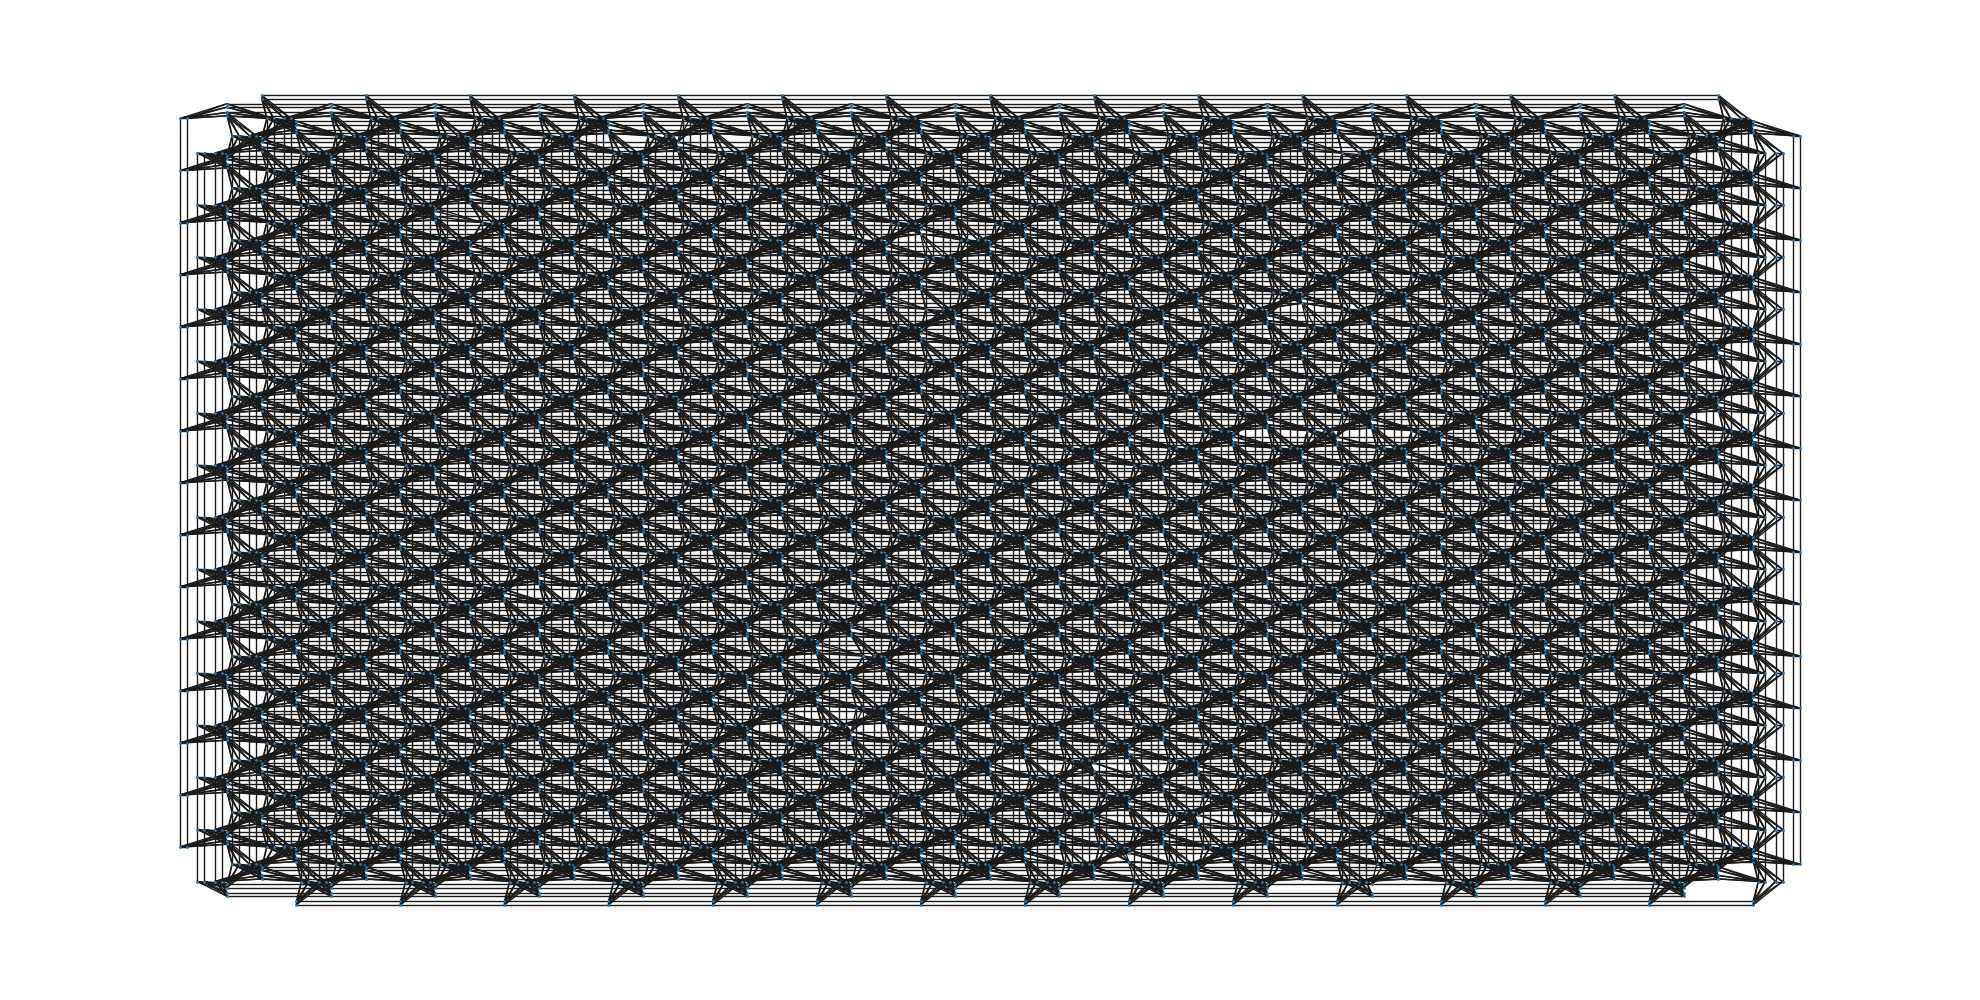

In [18]:
qpu = DWaveSampler()
qpu_edges = qpu.edgelist
qpu_nodes = qpu.nodelist
# pprint(dir(qpu))
if qpu.solver.id == "Advantage_system4.1":
    print(qpu.solver.id)
    X = dnx.pegasus_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_pegasus(X, node_size=1, width=1, )
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))

In [20]:
import dwave.inspector

In [ ]:

DwaveSampler = LazyFixedEmbeddingComposite(DWaveSampler())


In [19]:
DwaveSampler = DWaveCliqueSampler() 

In [ ]:
DwaveSampler.properties

In [ ]:
# tried zero qubit init /w various annealing schedules, did not work well. 
# Problem is the max chain length of the problem which is 14 when using CliqueSampler which suits well for this kind of dense QUBO matrix.
# Chain length under 7 is required for optimal performance.

init ={i:0 for i in range(0,135)}

In [ ]:
#schedule = [[0.0, 1.0], [25.0, 0.5], [50.0, 0.5], [60, 1.0]]
#schedule=[[0.0,1.0],[12.0,0.6],[12.8,1.0]]
#schedule=[[0.0, 1.0], [10.0, 0.4], [20.0, 0.4], [21.2, 1.0]]
# initial_state=init, anneal_schedule= schedule, 

In [20]:
alpha = [0.5, 0.7, 0.8, 0.9, 0.95]

for a in alpha:
    sampleset= run_dwave_experiment(Q, a, DwaveSampler, feature_names, num_reads=1000, chain_str=0.2, save_dir=f'results_{Q_name}_DWaveAnnealing')

minimum energy: -0.04923052713274956
Selected 2 model variables
minimum energy: -0.1416822886094451
Selected 3 model variables
minimum energy: -0.2756390266586095
Selected 4 model variables
minimum energy: -0.7063619321561418
Selected 5 model variables
minimum energy: -1.638041772035649
Selected 8 model variables


# Chain break detection (IMPORTANT!)

In [ ]:
dwave.inspector.show(sampleset)

In [ ]:
# Chain Break statistics for debugging

num_samples = 1000
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(
      np.count_nonzero(sampleset.record.chain_break_fraction > 0.10)/num_samples*100,
      np.count_nonzero(sampleset.record.chain_break_fraction > 0.10)/num_samples*100))

In [ ]:
sampleset.record.chain_break_fraction

In [ ]:
chains = sampleset.info["embedding_context"]["embedding"].values()  
print(max(len(chain) for chain in chains))

# Speed comparisons with Simulated Annealing

In [17]:
alpha = 0.5
Q_init = Q.copy()
#Q_init = upper_tri_qubo(Q_init)
Q_w = set_qubo_weights(Q_init, alpha)
model = dimod.BinaryQuadraticModel.from_qubo(Q_w)
sas= dwave.samplers.SimulatedAnnealingSampler()
simAnnSamples = sas.sample(model,num_reads= 100)

In [18]:
n = 100
t_sim= timeit.timeit(lambda:sas.sample(model,num_reads= 100), number=n) /n
t_dwave = 0.029911
print(f" {t_sim/t_dwave}")

 8.30928972618654


In [20]:
t_sim

0.2485391649999656

In [21]:
# Time using a supercomputer and simulated quantum annealing (SQA)
t_sqa = 0.003

In [22]:
t_dwave_annealing =1e-7
print(f" {t_sqa/t_dwave_annealing:e}")

 3.000000e+04


In [23]:
1/ 0.029911

33.43251646551436